In [ ]:
# TODO:
# 1. something is still off I think, the algorithms behavior is strange
# - the result does change quite a lot even if C changes just a little
# - if C changes in the first round, the result in the second round changes as well
# 2. finish the theory part

# Support Vector Machine (SVM)
-----

NOTE: Please read this notebook [here](). It is not rendered properly on Github.

This notebook was created using the concepts and ideas conveyed in Stanford's lecture/course *Machine Learning* by Andrew Ng. On top of that this implementation uses the [SMO](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf) algorithm to train the svm.

## Theory

A support vector machine is a classification algorithm. It determines a decision boundary which separates samples of different classes with as much of a largin as possible. The optimization problem while doing this is to maximize the mean distance between the boundary and all the data samples while still separating the different classes correctly. An example is shown in the following image:

![](graphics/linear.png)

There are two sets of objects (blue 'x' and red 'o') which are separated by the orange decision boundary. The goal of the svm is to maximize the mean distance between all the points and the decision boundary while still separating the two sets correctly. The orange decision boundary is not the only decision boundary which would be able to separate the two sets correctly. But it is the one which maximizes the margin between the the boundary and the samples. The classification of new samples after determining the decision boundary is trivial. If the point is to the right, it is classified as a red 'o' and blue 'x' if it is to the left).

While the decision boundary above is linear, there can also be non-linear decision boundaries. The following image shows an example of a non-linear decision boundary separating two sets of samples.

![](graphics/non-linear.png)

## Implementation

In [1]:
import numpy as np
import math

class SVM():
    
    def predict(self, x):
        """ Predict the labels of the given data points x.
        
        :parameter x: input data, an m x n matrix (m = number of points, n = dimensions/features)
        
        :return prediction: labels of the input data, an m x 1 matrix (<0 = negative, >0 = positive)
        """
        if self.kernel == "gaussian":
            K = self._calc_K(x, self.x_trained)
            prediction = np.zeros((x.shape[1]))
            for i in range(x.shape[1]):
                prediction[i] = np.sum(self.y_trained * self.alphas_trained * K[:,i]) - self.b
            return prediction
        
        elif self.kernel == "linear":
            return np.matmul(self.w, x) - self.b
    
    # uses SMO
    def fit(self, x, y, kernel="linear", C=1.0, tol=1e-3, sigma=1.0):
        """ Fit the given data by applying the smo algorithm (https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)
            
        :parameter x: the input data, an m x n matrix
        :parameter y: the output labels, an m x 1 vector
        :parameter C: the regularization parameter (comparable to 1/lambda in neural networks/regression analysis)
        :parameter tol: tolerance/epsilon for determining whether a point is eligible for optimization
        :parameter sigma: sigma of the gaussian kernel
        
        :return void: returns nothing but sets the results of training internally to be used by "predict"        
        """
        # init variables
        self.x = x
        self.y = y
        self.kernel = kernel
        self.alphas = np.zeros((y.shape[0],))
        self.C = C
        self.b = 0.0
        self.sigma = sigma
        self.K = self._calc_K(x, x)
        self.E = self._calc_E()
        self.tol = tol
        self.w = np.zeros((x.shape[0],))
        
        # start procedure
        numChanged = 0
        examineAll = True;

        while numChanged > 0 or examineAll:
            
            numChanged = 0
            if examineAll:
                # iterate over all examples
                for i2 in range(self.alphas.shape[0]):
                    numChanged += self._examineExample(i2)
            else:
                # iterate over examples where alpha is not 0 and C
                alpha_idx = np.where((self.alphas > 0) & (self.alphas < self.C))[0]
                for i2 in alpha_idx:
                    numChanged += self._examineExample(i2)

            if examineAll:
                examineAll = False
            elif numChanged == 0:
                examineAll = True
        
        # set the support vectors for this svm
        idx = self.alphas > 0
        self.alphas_trained = self.alphas[idx] 
        self.x_trained = self.x[:,idx]
        self.y_trained = self.y[idx]

    def _examineExample(self, i2):
        """ Determines whether the given lagrange multiplier is eligible for optimization. If it is then
            a second multiplier is chosen.
            
        :parameter i2: the first lagrange multiplier
        """
        y2 = self.y[i2]
        alph2 = self.alphas[i2]
        E2 = self.E[i2]
        r2 = E2 * y2

        if (r2 < -self.tol and alph2 < self.C) or (r2 > self.tol and alph2 > 0):

            if (np.where((self.alphas > 0) & (self.alphas < self.C))[0].shape[0] > 1):
                
                if E2 >= 0:
                    i1 = self.E.argmin()
                elif E2 < 0:
                    i1 = self.E.argmax()
                
                if self._takeStep(i1,i2):       
                    return 1     

            # iterate over alphas non-zero and non-C starting at a random point
            alpha_idx = np.where((self.alphas > 0) & (self.alphas < self.C))[0]
            r = math.floor(random.random() * alpha_idx.shape[0])
            to_iterate_over = np.concatenate((alpha_idx[r:], alpha_idx[0:r]), axis=0)

            for i1 in to_iterate_over:         
                if self._takeStep(i1,i2):    
                    return 1    

            # iterate over alphas starting at a random point
            idx = range(self.alphas.shape[0])
            r = math.floor(random.random() * self.alphas.shape[0])
            to_iterate_over = np.concatenate((idx[r:], idx[0:r]), axis=0)

            for i1 in to_iterate_over:      
                if self._takeStep(i1,i2):
                    return 1   
        return 0

    def _takeStep(self, i1, i2):
        """ Optimizes two lagrange multipliers.
        
        :parameter i1: index of the first lagrange multiplier
        :parameter i2: index of the second lagrange multiplier
        """
        
        i1 = int(i1)
        i2 = int(i2)
        
        if i1 == i2:
            return 0
        
        alph2 = self.alphas[i2]
        y2 = self.y[i2]
        E2 = self.E[i2]

        alph1 = self.alphas[i1]
        y1 = self.y[i1]
        E1 = self.E[i1]
        
        s = y1 * y2

        if y1 == y2:
            L = max(0, alph2 + alph1 - self.C)
            H = min(self.C, alph2 + alph1)
        else:
            L = max(0, alph2 - alph1)
            H = min(self.C, self.C + alph2 - alph1)

        if L == H:
            return 0

        k11 = self.K[i1,i1]
        k12 = self.K[i1,i2]
        k22 = self.K[i2,i2]
        eta = k11 + k22 - 2 * k22

        if eta > 0:
            a2 = alph2 + y2 * (E1 - E2) / eta
            if a2 < L:
                a2 = L      
            elif a2 > H:
                a2 = H
        else:
            f1 = y1 * (E1 + self.b) - alph1 * self.K[i1,i1] - s * alph2 * self.K[i1,i2]
            f2 = y2 * (E2 + self.b) - s * alph1 * self.K[i1,i2] - alph2 * self.K[i2,i2]

            L1 = alph1 + s * (alph2 - L)
            H1 = alph1 + s * (alph2 - H)

            Lobj = L1 * f1 + L * f2 + 1/2 * L1 ** 2 * self.K[i1,i1] \
                + 1/2 * L ** 2 * self.K[i2,i2] + s * L * L1 * self.K[i1,i2]     
            Hobj = H1 * f1 + H * f2 + 1/2 * H1 ** 2 * self.K[i1,i1] \
                + 1/2 * H ** 2 * self.K[i2,i2] + s * H * H1 * self.K[i1,i2] 

            if Lobj < Hobj - self.tol:         
                a2 = L      
            elif Lobj > Hobj + self.tol:        
                a2 = H      
            else:
                a2 = alph2

        if abs(a2 - alph2) < self.tol * (a2 + alph2 + self.tol):
            return 0   

        a1 = alph1 + s * (alph2 - a2)   
 
        b1 = E1 + y1 * (a1 - alph1) * self.K[i1,i1] + y2 * (a2 - alph2) * self.K[i1,i2] + self.b
        b2 = E2 + y1 * (a1 - alph1) * self.K[i1,i2] + y2 * (a2 - alph2) * self.K[i2,i2] + self.b

        if 0 < a1 and a1 < self.C:
            self.b = b1
        elif 0 < a2 and a2 < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2
        
        self.alphas[i1] = a1
        self.alphas[i2] = a2
        
        self.E[i1] = self.__calc_E(i1)
        self.E[i2] = self.__calc_E(i2)
        
        self.w = self.w + y1 * (a1 - alph1) * self.x[:,i1] + y2 * (a2 - alph2) * self.x[:,i2]
        return 1

    def _gaussian_kernel(self, x1, x2, sigma):
        """ Gaussian kernel for the svm.
        
        :parameter x1: first point
        :parameter x2: second point
        :parameter sigma: determines the slope of the function (the bigger it is the more steep it is)
        
        :return value: the result of the kernel
        """
        return np.exp(-(np.power(x2 - x1, 2).sum() / (2 * sigma ** 2)));
    
    def _linear_kernel(self, x1, x2):
        """ Linear kernel for the svm.
        
        :parameter x1: first point
        :parameter x2: second point
        
        :return value: the result of the kernel
        """
        return np.matmul(x1, x2)
    
    def _calc_K(self, x, landmarks):
        """ Calculate the features of x for the landmarks given the gaussian kernel.
        
        :parameter x: data points used for training
        :parameter landmarks: the landmarks the svm uses for it's feature calculation
        :parameter sigma: sigma of the gaussian kernel
        
        :return K: a matrix where K[j, i] corresponds of the value of the gaussian
                   kernel for landmark j and data point i
        """
        # measure dimensions of input/landmarks
        n, m = landmarks.shape
        _, m_ = x.shape

        # initialize array to calc distances with kernel
        K = np.zeros((m, m_))

        # calculate distances between input data/landmarks using the given kernel
        for i in range(m_):
            for j in range(m):
                if self.kernel == "gaussian":
                    K[j, i] = self._gaussian_kernel(landmarks[:,j], x[:,i], self.sigma)
                elif self.kernel == "linear":
                    K[j, i] = self._linear_kernel(landmarks[:,j], x[:,i])

        return K
    
    def __calc_E(self, i):
        """ Calculates the error given a data point i.
        
        :parameter i: the index of the point to calculate the error for
        
        :result error: the error of the classification        
        """
        return np.sum(self.y * self.alphas * self.K[:,i], axis=0) - self.b - self.y[i]
    
    def _calc_E(self):
        """ Calculates the error for every data point.
        
        :result error: an error matrix E where E[i] corresponds to the error for the data point i       
        """
        E = np.zeros((self.y.shape[0],))
        for i in range(self.y.shape[0]):
            E[i] = self.__calc_E(i)
        return E
    

## Data

### Linear

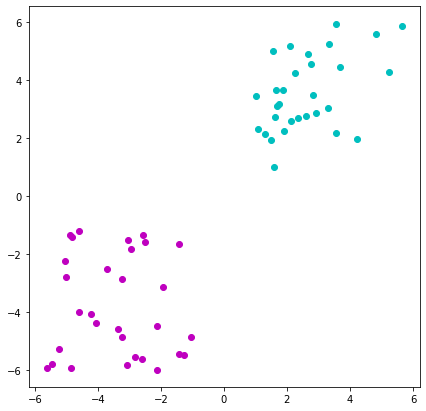

In [2]:
import random

# set seed for reproducibility
np.random.seed(123423234)
random.seed(123423234)

# generate two random sets of points
num_points = 30
it = (np.random.rand(2, num_points) - 0.5) * 5 - 3.5
not_it = (np.random.rand(2, num_points) - 0.5) * 5 + 3.5

# plot the result
%matplotlib inline
import matplotlib.pyplot as plt

# plot the the generated sets
plt.figure(1, figsize=(7,7))
plt.plot(it[0,:], it[1,:], 'mo')
plt.plot(not_it[0,:], not_it[1,:], 'co')
plt.show()

# combine the x/y of the sets for training
y_l = np.concatenate((np.zeros((not_it.shape[1],)), np.ones((it.shape[1],))), axis=0)
x_l = np.concatenate((not_it, it), axis=1)

### Non-Linear

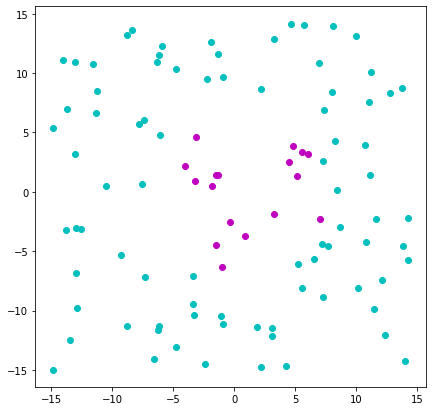

In [3]:
# generate a random set of points
num_points = 100
not_it = (np.random.rand(2, num_points) - 0.5) * 30

it_x = [0]
it_y = [0]

# function to compare a point of the generated data to the "other points"
# to determine whether the point is "it" or not
def isNear(point, to_compare_to, dist_thresh):
    x, y = to_compare_to
    
    for i in range(len(x)):
        dist = math.sqrt((x[i] - point[0])**2 + (y[i] - point[1])**2)
        if dist < dist_thresh:
            return True
    return False
    

label = np.zeros((num_points,))
for i in range(num_points):
    if isNear(not_it[:,i], (it_x, it_y), 7.5):
        label[i] = 1
    else:
        label[i] = 0

it = not_it[:,label==1]
not_it = not_it[:,label==0]

# plot the result

# plot the the generated sets
plt.figure(2, figsize=(7,7))
plt.plot(it[0,:], it[1,:], 'mo')
plt.plot(not_it[0,:], not_it[1,:], 'co')
plt.show()

# combine the x/y of the sets for training
y_nl = np.concatenate((np.zeros((not_it.shape[1],)), np.ones((it.shape[1],))), axis=0)
x_nl = np.concatenate((not_it, it), axis=1)

## Applying the algorithm

### Linear

In [4]:
# Init the algorithm
svm_linear = SVM()

# train svm
y_l[y_l==0] = -1
svm_linear.fit(x_l, y_l, kernel="linear", C=.5, tol=0.001)

# predict the data
predictions = svm_linear.predict(x_l)
print(predictions)

# set labels based on prediction
predictions[predictions>=0] = 1
predictions[predictions<0] = 0
print(predictions)

[ -1.36286141 -15.1136737  -39.88428996  -5.98698992 -30.249623
 -16.35896649 -20.30017958 -21.52565636 -16.92224475 -30.81089579
 -11.78359272 -10.67730989  -7.51713919 -20.20150947 -12.53668628
 -26.212704    -6.72991487  -1.43841823 -15.19778902 -23.84855625
 -14.0222956   -9.11928399  -1.63463592  -8.72853541 -34.76320173
 -10.75238277 -12.09643944   2.74573461  -8.10120774  -4.74573461
  48.74416227  48.191855    33.54334202  54.1522791   44.17243618
  66.96127078  37.56427842  44.54631652  68.90384223  49.35826818
  29.92536259  54.72754826  44.28253243  34.46637182  56.12242225
  39.69649745  55.62719319  70.46696502  47.07393949  42.00751414
  44.02587804  55.65645552  54.62161528  53.4043215   51.96204985
  36.54826808  65.32078726  58.20282391  44.05608265  55.03481421]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


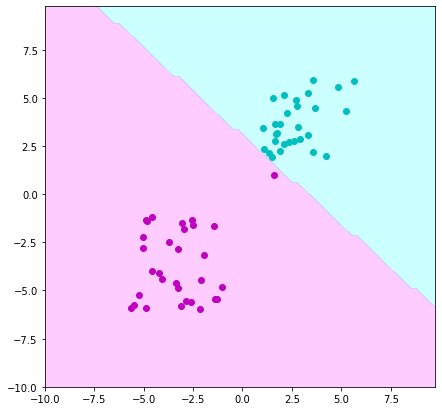

In [5]:
# prepare the predictions for plotting
predicted_it = x_l[:,predictions==1]
predicted_not_it = x_l[:,predictions==0]

### create decision boundary
t = 10
s = 0.25
dim = round(t * 2 * 1/s)
num = round((t * 2 * 1/s) ** 2)
x_, y_ = np.meshgrid(np.arange(-t,t,s), np.arange(-t,t,s))
x_ = x_.reshape((1, num))
y_ = y_.reshape((1, num))
data = np.concatenate((x_, y_), axis=0)

# get predictions of the data
prediction_dec = svm_linear.predict(data)

# set labels based on prediction
prediction_dec[prediction_dec>=0] = 1
prediction_dec[prediction_dec<0] = 0

## plot the predictions and the decision boundary
plt.figure(4, figsize=(7,7))
# plot the data points
plt.plot(predicted_it[0,:], predicted_it[1,:], 'mo')
plt.plot(predicted_not_it[0,:], predicted_not_it[1,:], 'co')
# plot the decision boundary
plt.contourf(x_.reshape((dim,dim)), y_.reshape((dim,dim)), prediction_dec.reshape((dim,dim)), \
             1, alpha=0.2, colors=["cyan", "magenta"])
plt.show()

### Non-Linear

In [6]:
# Init the algorithm
svm_nl = SVM()

# train svm
y_nl[y_nl==0] = -1
svm_nl.fit(x_nl, y_nl, kernel="gaussian", C=1.5, sigma=1.75)

# predict the data
predictions = svm_nl.predict(x_nl)
print(predictions)

# set labels based on prediction
predictions[predictions>=0] = 1
predictions[predictions<0] = 0
print(predictions)

[-0.28099022 -0.31300041 -0.43411425 -1.01181617 -0.68916009 -1.31726249
 -0.27168789 -0.27806527 -0.41223768 -0.74283389 -0.28725071 -0.27154927
 -0.21780707 -2.74779918 -0.58922606 -0.41366913 -1.09665031 -0.4035551
 -0.27177545 -0.47804501 -0.29559373 -0.27299763  1.84355852 -0.19793756
 -0.27164828 -0.6442227  -0.2715514  -0.93004807 -0.28006676 -2.32572405
 -0.48864085 -3.21536313 -0.2993104  -0.27154112 -0.78889826 -1.08586046
 -0.60336486 -0.27162125 -0.35272891 -1.01358886 -0.05608268 -1.78165981
 -2.15602566 -2.34494742  0.44756486 -0.8943601  -0.30210506 -1.07177529
 -0.4924875  -2.1900295  -2.37552988 -3.21537828 -0.85018014 -1.81135954
 -1.77622147 -1.34170703 -0.20104593  0.37071093 -0.27154274 -0.96563389
 -1.26557135 -1.91675974 -0.27322068 -2.69792951 -0.27796458 -2.61776227
 -1.51928064 -1.82135361 -1.84783054 -2.16689821 -0.31407563 -0.2715897
 -0.62979995 -0.25617601 -1.25170975 -0.42888071 -0.31791438 -0.2733581
 -0.26866374 -1.46047105 -0.27162739  0.05658737 -0.59

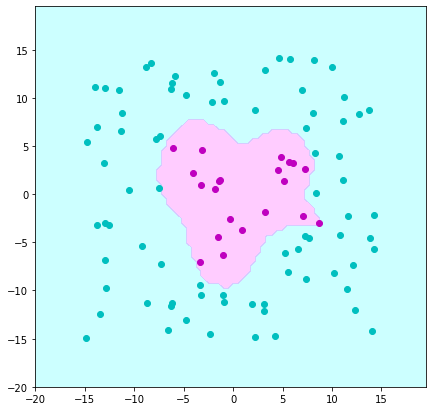

In [7]:
# prepare the predictions for plotting
predicted_it = x_nl[:,predictions==1]
predicted_not_it = x_nl[:,predictions==0]

### create decision boundary
t = 20
s = 0.5
dim = round(t * 2 * 1/s)
num = round((t * 2 * 1/s) ** 2)
x_, y_ = np.meshgrid(np.arange(-t,t,s), np.arange(-t,t,s))
x_ = x_.reshape((1, num))
y_ = y_.reshape((1, num))
data = np.concatenate((x_, y_), axis=0)

# get predictions of the data
prediction_dec = svm_nl.predict(data)

# set labels based on prediction
prediction_dec[prediction_dec>=0] = 1
prediction_dec[prediction_dec<0] = 0

## plot the predictions and the decision boundary
plt.figure(4, figsize=(7,7))
# plot the data points
plt.plot(predicted_it[0,:], predicted_it[1,:], 'mo')
plt.plot(predicted_not_it[0,:], predicted_not_it[1,:], 'co')
# plot the decision boundary
plt.contourf(x_.reshape((dim,dim)), y_.reshape((dim,dim)), prediction_dec.reshape((dim,dim)), \
             1, alpha=0.2, colors=["cyan", "magenta"])
plt.show()

## Testing

The following code sections can be ignored.

In [8]:
%%script false 

UsageError: %%script is a cell magic, but the cell body is empty.


In [ ]:
a = np.array([1,2])
b = np.array([[1,2,3,4],[1,2,3,4]])

print(a.shape)
print(b.shape)

print(np.matmul(a,b))

In [ ]:
a = np.zeros((40,1))

print(a.argmax(axis=1))